In [1]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import importlib
import shutil
import math
import os
from pathlib import Path
import warnings

sys.path.append('../utilities')
sys.path.append('../models/grt123')
sys.path.append('../models/grt123/training')
sys.path.append('../models/grt123/preprocessing/')

from layers import nms,iou
from summit_utils import *
from evaluation import noduleCADEvaluation


warnings.simplefilter('ignore')

MIN_THRESHOLD = -10000000

%matplotlib inline

No handles with labels found to put in legend.
No handles with labels found to put in legend.


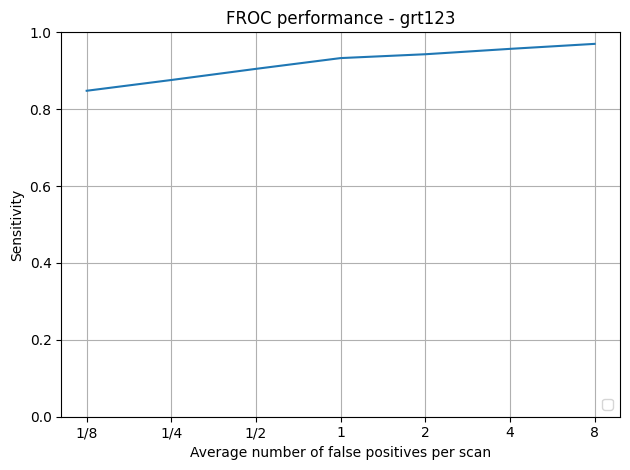

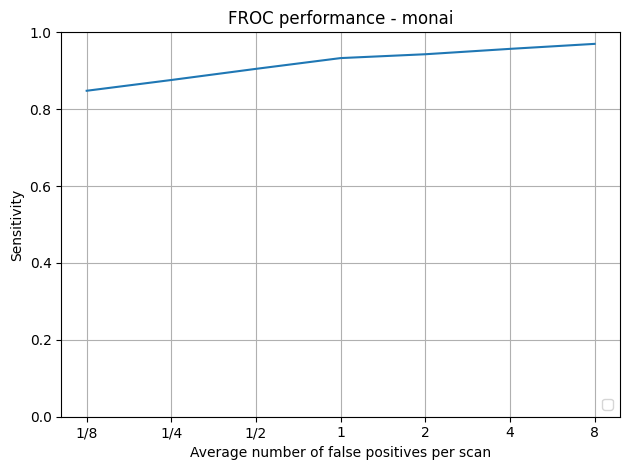

In [2]:
# LUNA16 Results Trained on LUNA16
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data = [
    row.split('\t')
    for row in """
    Methods	1/8	1/4	1/2	1	2	4	8
    Liu et al. (2019)	0.848	0.876	0.905	0.933	0.943	0.957	0.970
    nnDetection (2021)	0.812	0.885	0.927	0.950	0.969	0.979	0.985
    MONAI detection	0.835	0.885	0.931	0.957	0.974	0.983	0.988
    """.split('\n')
    if row
]
data = pd.DataFrame(data).transpose().drop(0).drop(4, axis=1).rename(columns={0:'FPR',1:'grt123',2:'nnDetection',3:'monai'})
data[['grt123','nnDetection','monai']] = data[['grt123','nnDetection','monai']].astype(float)

def display_froc(fpr, recall, CADSystemName):

    fig1 = plt.figure()
    ax = plt.gca()
    ax.plot(recall, fpr)
    ax.set_xlabel('Recall')
    ax.set_ylabel('False positive rate')
    plt.plot()
    plt.ylim(0, 1)
    plt.xlabel('Average number of false positives per scan')
    plt.ylabel('Sensitivity')
    plt.legend(loc='lower right')
    plt.title('FROC performance - %s' % (CADSystemName))
    plt.grid(visible=True, which='both')
    plt.tight_layout()


display_froc(np.array(data.grt123), np.array(data.FPR), 'grt123')

display_froc(np.array(data.grt123), np.array(data.FPR), 'monai')

# GRT123 Evaluation

In [3]:


RESULTS_PATH = '../output/results'
METADATA_PATH = '../output/metadata'
BBOX_RESULTS_PATH = '../models/grt123/bbox_result'
MODEL = 'GRT123'
NAME = 'all'
PHASE = 'validation'

combined_predictions = pd.read_csv(Path(BBOX_RESULTS_PATH, NAME, 'predictions.csv'))
combined_nodule_data = pd.read_csv(Path(BBOX_RESULTS_PATH, NAME, 'metadata.csv'))
scans_list = pd.read_csv(Path(METADATA_PATH, NAME, PHASE + '_scans.csv'))['scan_id'].tolist()

print('Prediction:{}, Nodules:{}, Scans:{}'.format(
    combined_predictions.shape[0],
    combined_nodule_data.shape[0],
    len(scans_list)
))

Prediction:91773, Nodules:2866, Scans:1783


In [4]:
display(combined_nodule_data.ethnic_group.value_counts())
display(combined_nodule_data.head())

ethnic_group
White                     2264
Asian or Asian British     299
Black                      172
Other ethnic groups         74
Mixed                       57
Name: count, dtype: int64

,id,main_form_instance_id,main_form_instance_status,main_participant_id,main_created_time,form_instance_status,participant_id,index,nodule_brock_score,nodule_category,...,nodule_x_coordinate,nodule_y_coordinate,nodule_z_coordinate,ethnic_group,management_plan,row,col,diameter,threshold,name
0,12,0ZKAM3Jz5_W9hwXTjmG3SkPSwrFwvn5OJjSSm6P7hR4,COMPLETED,summit-2255-hey,2019-08-31 08:40:57,COMPLETED,summit-2255-hey,42.884998,0.0,BASELINE,...,-114.07,51.21,-227.74,White,RANDOMISATION_AT_YEAR_1,170.410004,46.730003,5.381250,-10000000,summit-2255-hey_Y0_BASELINE_A
1,13,0ZKAM3Jz5_W9hwXTjmG3SkPSwrFwvn5OJjSSm6P7hR4,COMPLETED,summit-2255-hey,2019-08-31 08:40:57,COMPLETED,summit-2255-hey,57.275002,0.0,BASELINE,...,-91.38,-19.73,-213.35,White,RANDOMISATION_AT_YEAR_1,99.469994,69.420006,5.250000,-10000000,summit-2255-hey_Y0_BASELINE_A
2,14,OknVl3ECnss67Ucy3LjGUNMxIwtJGthc8_TAdrlLmNk,COMPLETED,summit-2262-tta,2019-09-28 14:40:44,COMPLETED,summit-2262-tta,145.649994,0.0,BASELINE,...,-103.96,-53.20,-158.10,White,RANDOMISATION_AT_YEAR_1,73.800003,54.040001,2.756250,-10000000,summit-2262-tta_Y0_BASELINE_A
3,15,OknVl3ECnss67Ucy3LjGUNMxIwtJGthc8_TAdrlLmNk,COMPLETED,summit-2262-tta,2019-09-28 14:40:44,COMPLETED,summit-2262-tta,126.120003,0.0,BASELINE,...,-32.41,70.73,-177.63,White,RANDOMISATION_AT_YEAR_1,197.729996,125.589996,3.346875,-10000000,summit-2262-tta_Y0_BASELINE_A
4,16,OknVl3ECnss67Ucy3LjGUNMxIwtJGthc8_TAdrlLmNk,COMPLETED,summit-2262-tta,2019-09-28 14:40:44,COMPLETED,summit-2262-tta,210.020004,0.0,BASELINE,...,56.12,49.87,-93.73,White,RANDOMISATION_AT_YEAR_1,176.869995,214.119995,2.690625,-10000000,summit-2262-tta_Y0_BASELINE_A


../output/results/GRT123/all/nodule_annotations.csv
Total number of included nodule annotations: 4887
Total number of nodule annotations: 13564
Ethnicity: White, Scans:2264, Nodules:72
../output/results/GRT123/all/nodule_annotations.csv
Total number of included nodule annotations: 542
Total number of nodule annotations: 4271
Ethnicity: Asian or Asian British, Scans:299, Nodules:36
../output/results/GRT123/all/nodule_annotations.csv
Total number of included nodule annotations: 364
Total number of nodule annotations: 1538
Ethnicity: Black, Scans:172, Nodules:38


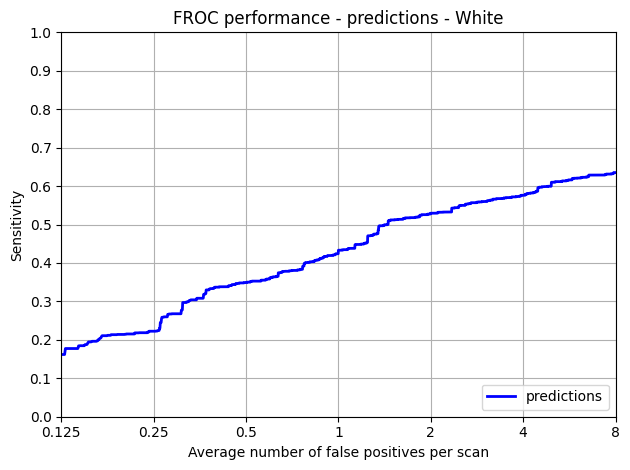

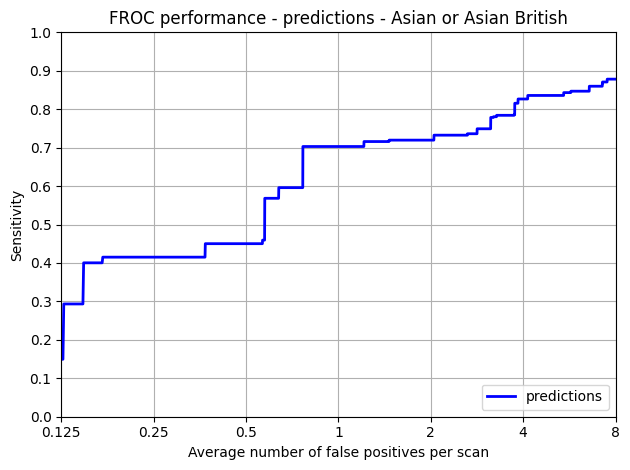

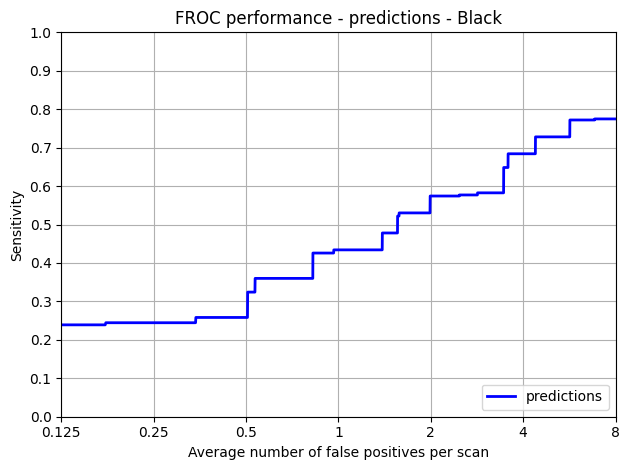

In [11]:


"""
    The evaluation script accepts 4 parameters

    1. annotations_filename: csv file with following headers:
        - threshold
        - index
        - row
        - col
        - diameter
        - nodule_type
        - brock_score
        - management_plan
        - ethnic_group

    NOTE: Additional nodule fields will need to be added in eval script, fields are hard-coded
    into a nodule class

    2. annotations_excluded_filename: csv containing non-actionable or benign lesions,
    headers as per annotations_filename

    3. seriesuids_filename: single column csv file holding just the scan identifiers

    4. results_filename: csv containing the candidates generated from the detection algorithm.
    Headers as follows:
        - threshold
        - index
        - row
        - col
        - diameter

    5. outputdir: folder to output results to

"""
def FROCScores(combined_nodule_data, combined_predictions, output_dir, ethnicity, max):
    exclude  = combined_nodule_data.management_plan=='RANDOMISATION_AT_YEAR_1'
    include_nodule_data = combined_nodule_data[~exclude]
    exclude_nodule_data = combined_nodule_data[exclude]

    results_dir = Path(output_dir, 'results')
    results_dir.mkdir(parents=True, exist_ok=True)

    annotations_filepath            = Path(output_dir, 'nodule_annotations.csv')
    annotations_exclude_filepath    = Path(output_dir, 'nodule_exclude_annotations.csv')
    predictions_filepath            = Path(output_dir, 'predictions.csv')
    scanlist_filepath               = Path(output_dir, 'scanslist.csv')


    include_nodule_data.to_csv(annotations_filepath, index=False)

    exclude_nodule_data.to_csv(annotations_exclude_filepath, index=False)

    combined_predictions.to_csv(predictions_filepath, index=False)

    with open(scanlist_filepath, 'w') as f:
        N = max if max < sum(combined_nodule_data.ethnic_group==ethnicity) else sum(combined_nodule_data.ethnic_group==ethnicity)
        for idx, row in combined_nodule_data[combined_nodule_data.ethnic_group==ethnicity].sample(n=N, random_state=42).iterrows():
            f.write(row['participant_id']+'_Y0_BASELINE_A')
            f.write('\n')

    noduleCADEvaluation(annotations_filename=annotations_filepath,
                        annotations_excluded_filename=annotations_exclude_filepath,
                        seriesuids_filename=scanlist_filepath,
                        results_filename=predictions_filepath,
                        outputDir=output_dir,
                        ethnicity=ethnicity)
    


for ethnicity in ['White', 'Asian or Asian British', 'Black']:
    output_dir = Path(RESULTS_PATH, MODEL, NAME)
    output_dir.mkdir(parents=True, exist_ok=True)
    FROCScores(combined_nodule_data, combined_predictions, output_dir, ethnicity, 10000)

In [ ]:
# check the misses


def miss_check(model_name):
    misses = (
                pd.read_csv(f'../output/results/{model_name}/nodulesWithoutCandidate_{model_name}_predictions.txt', header=None)
                .rename(columns={
                    0:'name',
                    1:'idx',
                    2:'col',
                    3:'row',
                    4:'index',
                    5:'diameter',
                    6:'candidate_idx'}
                )
    )

    misses = (
                misses
                .merge(combined_nodule_data, left_on='idx', right_on='id', suffixes=['_miss', ''])
                .merge(validation_metadata, left_on='idx', right_index=True, suffixes=['', '_md'])
    )


    # Check distribution of type vs base distribution to see if one
    # type of nodule is being missed
    print('Nodule Type')
    print((pd.concat([
        misses.nodule_type.value_counts(normalize=True).rename('misses (%)'),
        validation_metadata.nodule_type.value_counts(normalize=True).rename('all (%)')
    ], axis=1).fillna(0) * 100).astype(int))

    print(2 * '\n')
    print('Management Plan')
    print((pd.concat([
        misses.management_plan.value_counts(normalize=True).rename('misses (%)'),
        validation_metadata.management_plan.value_counts(normalize=True).rename('all (%)')
    ], axis=1).fillna(0) * 100).astype(int))

    print(2 * '\n')
    print('Nodule Site')
    print((pd.concat([
        misses.nodule_site.value_counts(normalize=True, dropna=False).rename('misses (%)'),
        validation_metadata.nodule_site.value_counts(normalize=True, dropna=False).rename('all (%)')
    ], axis=1).fillna(0) * 100).astype(int))


    print(2 * '\n')
    print('Nodule Diameter')
    print((pd.concat([
        misses.diameter.describe().rename('misses (%)'),
        validation_metadata.nodule_diameter_mm.describe().rename('all (%)')
    ], axis=1)))


    print(2 * '\n')
    print('All - Site by Type (%)')
    display(
    (    pd.crosstab(
            validation_metadata.nodule_type,
            validation_metadata.nodule_site,
            margins=True,
            normalize=True
        ) * 100).astype(int)
    )

    print(2 * '\n')
    print('Misses - Site by Type (%)')
    display(
    (    pd.crosstab(
            misses.nodule_type,
            misses.nodule_site,
            margins=True,
            normalize=True
        ) * 100).astype(int)
    )

def get_missed_image_details(model_name):

    misses = (
            pd.read_csv(f'../output/results/{model_name}/nodulesWithoutCandidate_{model_name}_predictions.txt', header=None)
            .rename(columns={
                0:'name',
                1:'idx',
                2:'col',
                3:'row',
                4:'index',
                5:'diameter',
                6:'candidate_idx'}
            ))

    misses = misses.merge(validation_metadata.rename(columns={'index':'nodule_index'}), left_on='idx', right_index=True)

    return [
        (
            missed_nodule['name'],
            Ircd(
                index=int(missed_nodule['index']),
                row=int(missed_nodule['row']),
                col=int(missed_nodule['col']),
                diameter=int(missed_nodule['diameter'])
            ),
            missed_nodule['nodule_type'])
        for idx, missed_nodule in misses.iterrows()
    ]

miss_check('grt123')

grt123_missed_image_details = get_missed_image_details('grt123')

# Detection Evaluation

In [ ]:
"""
    The evaluation script accepts 4 parameters

    1. annotations_filename: csv file with following headers:
        - threshold
        - index
        - row
        - col
        - diameter
        - nodule_type
        - brock_score
        - management_plan

    NOTE: Additional nodule fields will need to be added in eval script, fields are hard-coded
    into a nodule class

    2. annotations_excluded_filename: csv containing non-actionable or benign lesions,
    headers as per annotations_filename

    3. seriesuids_filename: single column csv file holding just the scan identifiers

    4. results_filename: csv containing the candidates generated from the detection algorithm.
    Headers as follows:
        - threshold
        - index
        - row
        - col
        - diameter

    5. outputdir: folder to output results to

"""

detect_nodule_annotations = (
    validation_metadata
    .rename(
    columns={
        'index' : 'idx',
        'nodule_x_coordinate' : 'col',
        'nodule_y_coordinate' : 'row',
        'nodule_z_coordinate' : 'index',
        'nodule_diameter_mm' : 'diameter'
    })
    .assign(name=lambda df: df.main_participant_id + '_Y0_BASELINE_A')
    .assign(threshold=MIN_THRESHOLD)
)[['name','threshold','index','row','col','diameter','nodule_type','nodule_brock_score','management_plan']]
detect_nodule_annotations.index.rename('id',inplace=True)

exclude = detect_nodule_annotations.management_plan=='RANDOMISATION_AT_YEAR_1'

detect_nodule_exclude_annotations = detect_nodule_annotations[exclude]
detect_nodule_exclude_annotations.to_csv('../output/results/detect_nodule_exclude_annotations.csv')

detect_nodule_include_annotations = detect_nodule_annotations[~exclude]
detect_nodule_include_annotations.to_csv('../output/results/detect_nodule_annotations.csv')

scan_list = pd.read_csv('../output/metadata/validation_scans.csv')['scan_id'].tolist()
with open('../output/results/detect_scanslist.csv', 'w') as f:
    for scan_id in scans_list:
        f.write(scan_id)
        f.write('\n')

In [ ]:
"""
Deconstruct the json output into the correct format of

    threshold
    index -> z
    row -> y
    col -> x
    diameter
    name -> scan_id
"""
import json
with open('../models/summit_detection/result/result_summit_fold0.json','r') as f:
    fold0_json = json.load(f)

predictions = {}
idx = 0
for image in fold0_json['validation']:
    name = image['image'].split('/')[-1].split('.',1)[0]
    
    for box, score in zip(image['box'], image['score']):
        prediction = {}
        prediction['threshold'] = score
        prediction['index'] = box[2]
        prediction['row'] = box[1]
        prediction['col'] = box[0]
        prediction['diameter'] = np.max(box[3:])
        prediction['name'] = name

        predictions[idx] = prediction
        idx+=1

detect_predictions = pd.DataFrame.from_dict(predictions,orient='index')
detect_predictions.to_csv('../output/results/detect_predictions.csv', index=False)

In [ ]:
# Reduce to subset
scans_subset = detect_predictions.name.unique()
detect_nodule_include_annotations = detect_nodule_include_annotations[detect_nodule_include_annotations.name.isin(scans_subset)]
detect_nodule_include_annotations.to_csv('../output/results/detect_nodule_annotations.csv')

detect_nodule_exclude_annotations = detect_nodule_exclude_annotations[detect_nodule_exclude_annotations.name.isin(scans_subset)]
detect_nodule_exclude_annotations.to_csv('../output/results/detect_nodule_exclude_annotations.csv')

with open('../output/results/detect_scanslist.csv', 'w') as f:
    for scan_id in scans_subset:
        f.write(scan_id)
        f.write('\n')


In [ ]:
noduleCADEvaluation(annotations_filename='../output/results/detect_nodule_annotations.csv',
                    annotations_excluded_filename='../output/results/detect_nodule_exclude_annotations.csv',
                    seriesuids_filename='../output/results/detect_scanslist.csv',
                    results_filename='../output/results/detect_predictions.csv',
                    outputDir='../output/results/detect')

In [ ]:
miss_check('detect')

detect_missed_image_details = get_missed_image_details('detect')

In [ ]:
# Check whether there are any nodules that both missed
from math import isclose

def same_nodule(miss_1, miss_2):

    if miss_1[0] == miss_2[0] and isclose(miss_1[1].diameter, miss_2[1].diameter, abs_tol=0.1):
        return True
    else:
        return False

both_missed = [
    grt_miss
    for grt_miss in grt123_missed_image_details
    for dct_miss in detect_missed_image_details
    if same_nodule(grt_miss, dct_miss)
]

